In [1]:
import sys
import os

package_path = '..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.config.config import load_config
config = load_config()
config

ExpConfig(runs=[49, 50, 52, 58, 60, 64, 67, 70, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110], param=ExpParams(hutch=<Hutch.EH1: 'eh1'>, detector=<Detector.JUNGFRAU2: 'jungfrau2'>, xray=<Xray.HARD: 'HX'>, pump_setting=<Hertz.THIRTY: '30HZ'>, x1=0, x2=1, y1=2, y2=3, sdd=1.3, dps=7.5e-05, beam_energy=9.7, sigma_factor=1, wavelength=1.2781876127134046), path=ExpPaths(load_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw', save_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw', param_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\DataParameter', image_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Image', mat_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Mat_files2', npz_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Npz_files', tif_dir='Y:\\240608_FXS\\raw_data\\h5\\type=raw\\Tif_files'))

In [39]:
from src.analyzer.loader import NpzLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from roi_rectangle import RoiRectangle

In [5]:
def get_npz_file_name(run, scan, config, comment=None):
    npz_dir: str = config.path.npz_dir
    file_name: str = f"run={run:0>4}_scan={scan:0>4}"
    if comment is not None:
        file_name += comment
    return os.path.join(npz_dir, file_name + ".npz")

# Load Data

In [30]:
run_num: int = 42
print("run_num:", run_num)
npz_dir = config.path.npz_dir
npz_file = os.path.join(npz_dir, f"run={run_num:0>4}_scan=0001.npz")
_data = NpzLoader(npz_file).data
for key, values in _data.items():
    print(f"{key} shape: {values.shape}")


run_num: 42
pon shape: (60, 514, 1030)
poff shape: (60, 514, 1030)
delay shape: (60,)


In [34]:
pon_images = np.maximum(_data["pon"], 0)
poff_images = np.maximum(_data["poff"], 0)
delays = np.maximum(_data["delay"], 0)
print("Pump Off Shape:", poff_images.shape)
print("Pump On Shape:", pon_images.shape)
print("Delays Shape:", delays.shape)

Pump Off Shape: (60, 514, 1030)
Pump On Shape: (60, 514, 1030)
Delays Shape: (60,)


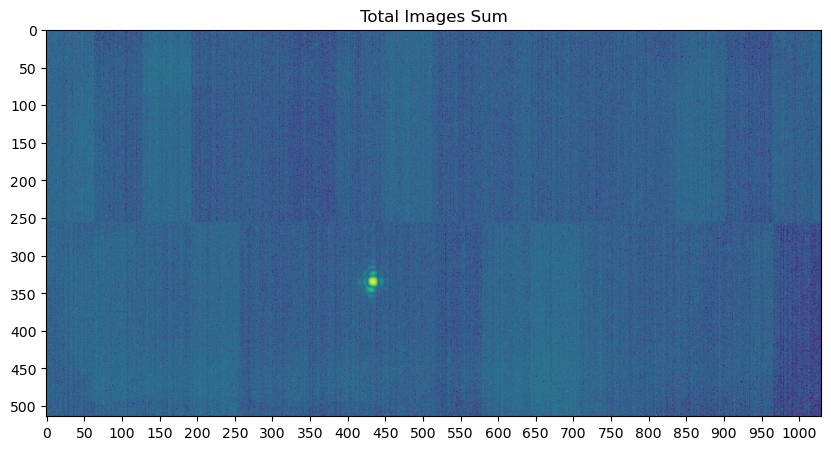

In [38]:
total_image_sum = np.sum(poff_images + pon_images, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(total_image_sum))
ax.set_title("Total Images Sum")
ax.set_yticks(np.arange(0, total_image_sum.shape[0], 50))
ax.set_xticks(np.arange(0, total_image_sum.shape[1], 50));

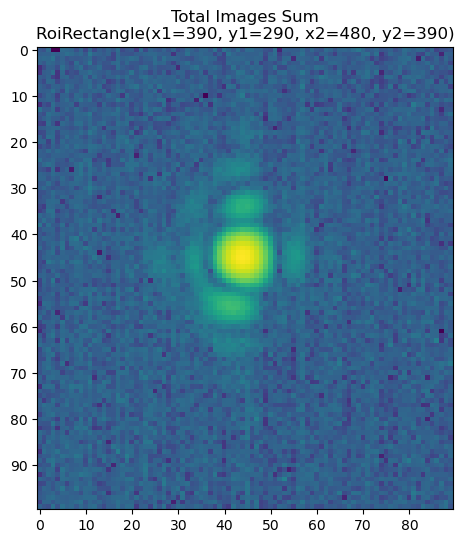

In [46]:
roi_rect = RoiRectangle(390, 290, 480, 390)
roi_image_sum = roi_rect.slice(total_image_sum)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log1p(roi_image_sum))
ax.set_title(f"Total Images Sum\n{roi_rect}")
ax.set_yticks(np.arange(0, roi_rect.height, 10))
ax.set_xticks(np.arange(0, roi_rect.width, 10));

In [22]:
from skimage.measure import moments, moments_central

features = {
    "delay": delays,
    "moment": [],
    "centroid_x": [],
    "centroid_y": [],
    "spread_x": [],
    "spread_y": [],
    "skewness_x": [],
    "skewness_y": [],
    "kurtosis_x": [],
    "kurtosis_y": []
}

for image in pon_images:

    M = moments(image, order=4)
    
    cx = M[1, 0] / M[0, 0]
    cy = M[0, 1] / M[0, 0]

    # 중심 모멘트 계산
    mu = moments_central(image, center=(cx, cy), order=4)

    # 분산 계산
    sigma_x2 = mu[2, 0]
    sigma_y2 = mu[0, 2]

    # 표준 편차 계산
    sigma_x = np.sqrt(sigma_x2)
    sigma_y = np.sqrt(sigma_y2)

    # 비대칭도 계산
    gamma_1 = mu[3, 0] / (sigma_x**3)
    gamma_2 = mu[0, 3] / (sigma_y**3)

    # 첨도 계산
    beta_1 = mu[4, 0] / (sigma_x**4)
    beta_2 = mu[0, 4] / (sigma_y**4)
    features["moment"].append(M)
    features["centroid_x"].append(cx)
    features["centroid_y"].append(cy)
    features["spread_x"].append(sigma_x2)
    features["spread_y"].append(sigma_y2)
    features["skewness_x"].append(gamma_1)
    features["skewness_y"].append(gamma_2)
    features["kurtosis_x"].append(beta_1)
    features["kurtosis_y"].append(beta_2)

Centroid: (260.318176093523, 503.99399791986514)
Spread (Variance): σ_x^2 = 1111047842.4914794, σ_y^2 = 4588260339.208908
Centroid: (258.76227937659496, 500.9869074551138)
Spread (Variance): σ_x^2 = 1097108912.6477735, σ_y^2 = 4547258610.382199
Centroid: (257.9121995250601, 499.45800778292073)
Spread (Variance): σ_x^2 = 935192074.0259073, σ_y^2 = 3880810004.936993
Centroid: (258.7551932574861, 501.31565406677475)
Spread (Variance): σ_x^2 = 901368651.5324721, σ_y^2 = 3739607836.4999013
Centroid: (258.4299363970825, 502.15431365946233)
Spread (Variance): σ_x^2 = 1012571012.5338541, σ_y^2 = 4095165932.989575
Centroid: (259.89314656545537, 494.2403270772267)
Spread (Variance): σ_x^2 = 1032409128.0595152, σ_y^2 = 4133952491.4853477
Centroid: (259.8296771310892, 491.13060196623417)
Spread (Variance): σ_x^2 = 1009624483.9106371, σ_y^2 = 4056233281.6613226
Centroid: (259.9991242964935, 506.62338088041605)
Spread (Variance): σ_x^2 = 964107297.2282528, σ_y^2 = 3899388661.875743
Centroid: (259.14